In [1]:
import torch
import torch.nn as nn

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channel_count, feature_d):
        """

        :param channel_count: how many color channels are there in the image
        :param feature_d:
        """
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            # Input: N x channel_count x 64 x 64
            nn.Conv2d(
                channel_count, feature_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self.block(feature_d, feature_d * 2),  # 16x16
            self.block(feature_d * 2, feature_d * 4),  #8x8
            self.block(feature_d * 4, feature_d * 8),  #4x4

            nn.Conv2d(feature_d * 8, 1, kernel_size=4, stride=2, padding=0),  # 1x1
            nn.Sigmoid()
        )

    @staticmethod
    def block(in_channels: int, out_channels: int,
              kernel_size: int = 4, stride: int = 2, padding: int = 1) -> nn.Sequential:
        """
        Get a building block of Discriminator
        :param in_channels:
        :param out_channels:
        :param kernel_size:
        :param stride:
        :param padding:
        :return:
        """
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x) -> torch.Tensor:
        return self.network(x)



In [3]:
class Generator(nn.Module):
    def __init__(self, noise_size, channel_count, features_g):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            self.block(noise_size, features_g * 16, stride=1, padding=0),  # N x f_g x 16 x 4 x 4
            self.block(features_g * 16, features_g * 8),  # 8x8
            self.block(features_g * 8, features_g * 4),  # 16x16
            self.block(features_g * 4, features_g * 2),  # 32x32

            nn.ConvTranspose2d(
                features_g * 2,
                channel_count,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.Tanh()  # -1 to 1
        )

    @staticmethod
    def block(in_channels: int, out_channels: int,
              kernel_size: int = 4, stride: int = 2, padding: int = 1) -> nn.Sequential:
        """
        Get a building block of Generator
        :param in_channels:
        :param out_channels:
        :param kernel_size:
        :param stride:
        :param padding:
        :return:
        """
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x) -> torch.Tensor:
        return self.network(x)


In [4]:
def initialize_weight(model):
    for m in model.modules():
        if isinstance(m, (
                nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d
        )):
            nn.init.normal_(m.weight.data, 0.0, 0.002)



In [5]:
def test():
    n = 8
    channel_count = 3
    h = 64
    w = 64

    noise_dim = 100
    x = torch.rand((n, channel_count, h, w))

    disc = Discriminator(channel_count, 8)
    initialize_weight(disc)

    # print(disc(x).shape)

    assert  disc(x).shape == (n, 1, 1, 1)

    gen = Generator(noise_dim, channel_count, 8)
    z = torch.randn((n, noise_dim, 1, 1))
    initialize_weight(gen)
    assert gen(z).shape == (n, channel_count, h, w)

    print("success")

# test()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.0002
batch_size = 128
image_size = 64
channel_count = 1
noise_dim = 100
num_epochs = 5
features_discriminator = 64
features_generate = 64

In [7]:
import torchvision
import torchvision.transforms as transforms

transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(channel_count)], [0.5 for _ in range(channel_count)]
    )
])


In [8]:
import torchvision.datasets as datasets
import torch.utils.data as data
# import SummaryWriter
from torch.utils.tensorboard import SummaryWriter
# import DataLoader
from torch.utils.data import DataLoader


dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)


loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

gen = Generator(noise_dim, channel_count, features_generate).to(device)
initialize_weight(gen)
gen.train()
disc = Discriminator(channel_count, features_discriminator).to(device)
initialize_weight(disc)
disc.train()

generator_optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))

discriminator_optimizer = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")


In [9]:
step = 0


for epoch in range(5):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)

        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake = gen(noise)

        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        discriminator_optimizer.step()
        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        generator_optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Mnist Real Images", img_grid_real, global_step=step)
                writer_fake.add_image("Mnist Fake Images", img_grid_fake, global_step=step)

                step += 1


Epoch [0/5] Batch 0/469                   Loss D: 0.6932, loss G: 0.6895
Epoch [0/5] Batch 100/469                   Loss D: 0.0311, loss G: 3.4227
Epoch [0/5] Batch 200/469                   Loss D: 0.0183, loss G: 4.1058
Epoch [0/5] Batch 300/469                   Loss D: 0.0043, loss G: 5.3488
Epoch [0/5] Batch 400/469                   Loss D: 0.9546, loss G: 2.6625
Epoch [1/5] Batch 0/469                   Loss D: 1.1623, loss G: 2.0822
Epoch [1/5] Batch 100/469                   Loss D: 0.6843, loss G: 0.6655
Epoch [1/5] Batch 200/469                   Loss D: 0.6538, loss G: 0.7261
Epoch [1/5] Batch 300/469                   Loss D: 0.6320, loss G: 0.7279
Epoch [1/5] Batch 400/469                   Loss D: 0.6606, loss G: 0.9413
Epoch [2/5] Batch 0/469                   Loss D: 0.6748, loss G: 0.5267
Epoch [2/5] Batch 100/469                   Loss D: 0.6697, loss G: 0.7422
Epoch [2/5] Batch 200/469                   Loss D: 0.6914, loss G: 0.6239
Epoch [2/5] Batch 300/469      

torch.Size([32, 1, 64, 64])
(1, 64, 64)


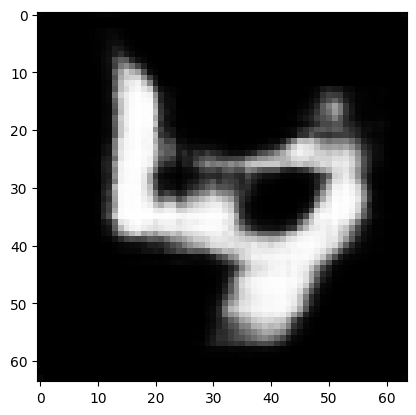

In [10]:
import PIL
import matplotlib.pyplot as plt

print(gen(fixed_noise).shape)
img = gen(fixed_noise)[0].detach().cpu().numpy()
print(img.shape)
plt.imshow(img.reshape(64, 64), cmap="gray")